# Fitting mixtures with COWs

This is a demo of how to use custom orthogonal weight functions (COWs) to generate weights which extract one component of a mixture. Find out more [in our paper](https://inspirehep.net/literature/1986730).

In [149]:
import numpy as np
from numba_stats import bernstein, norm, expon
import matplotlib.pyplot as plt
from scipy.integrate import quad
from typing import Callable

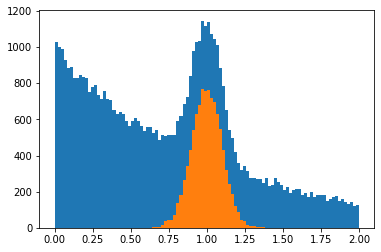

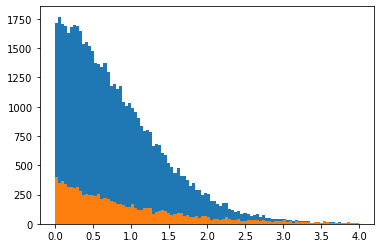

In [150]:
rng = np.random.default_rng(1)

s_x = rng.normal(1, 0.1, size=10000)
b_x = rng.exponential(1, size=100000)
s_y = rng.exponential(1, size=len(s_x))
b_y = rng.normal(0, 1, size=len(b_x))

x = np.append(s_x, b_x)
y = np.append(s_y, b_y)
id = np.append(np.ones_like(s_x, dtype=bool), np.zeros_like(b_x, dtype=bool))

xrange = 0, 2
yrange = 0, 4
m = (x > xrange[0]) & (x < xrange[1]) & (y > yrange[0]) & (y < yrange[1])
x = x[m]
y = y[m]
id = id[m]

s_x = x[id]
s_y = y[id]
b_x = x[~id]
b_y = y[~id]

plt.figure()
plt.hist(x, bins=100, range=xrange)
plt.hist(s_x, bins=100, range=xrange)

plt.figure()
plt.hist(y, bins=100, range=yrange)
plt.hist(s_y, bins=100, range=yrange);

In [151]:
def gs(m):
    return norm.pdf(m, 1, 0.1)

def gb(m):
    return expon.pdf(m, 0, 1)

def g(m):
    return gs(m) + 10 * gb(m) / 11.

def Gs(m):
    return norm.pdf(m, 1.1, 0.2)

def flat(m):
    return np.ones_like(m)

In [200]:
def _A(I, S, B, xrange=(-np.inf, np.inf)):
    nB = len(B)
    W = np.empty((1 + nB, 1 + nB))
    F = [S] + B
    for i in range(1 + nB):
        for j in range(i + 1):
            W[i, j] = quad(lambda m: F[i](m) * F[j](m) / I(m), *xrange)[0]
            if i != j:
                W[j, i] = W[i, j]
    return np.linalg.inv(W)

def cow(m, I, S, B, xrange=(-np.inf, np.inf)):
    if isinstance(B, Callable):
        B = [B]
    a = _A(I, S, B, xrange=xrange)
    F = [S(m)] + [Bi(m) for Bi in B]
    return (a[0] @ F) / I(m)

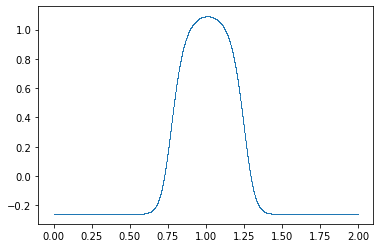

In [183]:
w0 = cow(x, g, gs, gb, xrange=xrange)
plt.plot(x, w0, ".", ms=1, mew=0);

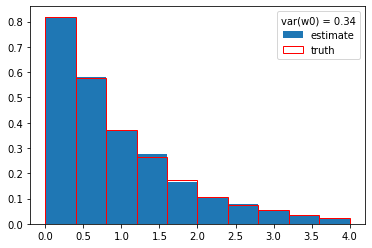

In [184]:
plt.hist(y, weights=w0, density=True, label="estimate")
plt.hist(s_y, density=True, edgecolor="r", facecolor="None", label="truth")
plt.legend(title=f"var(w0) = {np.var(w0):.2f}");

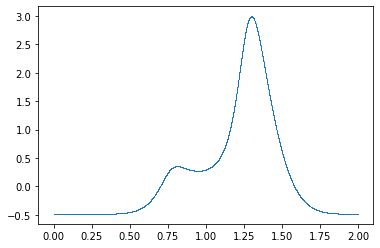

In [185]:
w0 = cow(x, g, Gs, gb, xrange=xrange)
plt.plot(x, w0, ".", ms=1, mew=0);

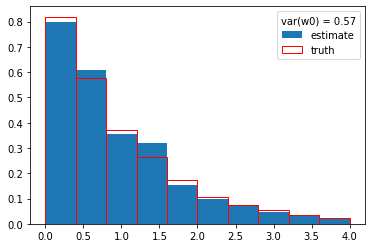

In [186]:
plt.hist(y, weights=w0, density=True, label="estimate")
plt.hist(s_y, density=True, edgecolor="r", facecolor="None", label="truth")
plt.legend(title=f"var(w0) = {np.var(w0):.2f}");

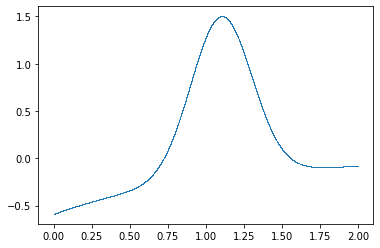

In [187]:
w0 = cow(x, flat, Gs, gb, xrange=xrange)
plt.plot(x, w0, ".", ms=1, mew=0);

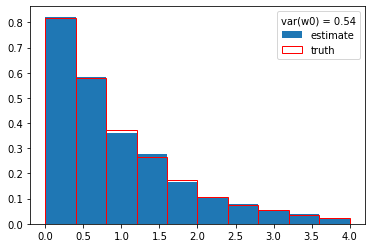

In [188]:
plt.hist(y, weights=w0, density=True, label="estimate")
plt.hist(s_y, density=True, edgecolor="r", facecolor="None", label="truth")
plt.legend(title=f"var(w0) = {np.var(w0):.2f}");

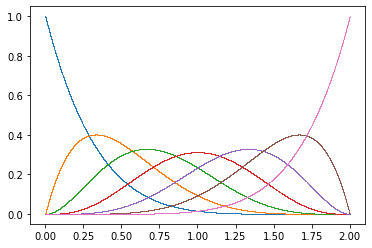

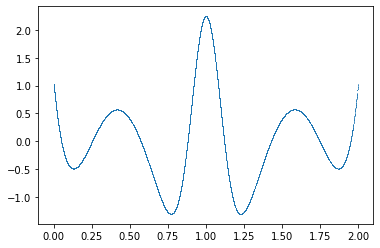

In [280]:
import numba as nb

class Base:
    def __init__(self, n, i, xrange):
        self.beta = np.zeros(n)
        self.beta[i] = 1
        self.xrange = xrange

    def __call__(self, m):
        return bernstein.density(m, self.beta, *self.xrange)

def make_basis(n, xrange):
    return [Base(n, i, xrange) for i in range(n)]

N = 7
B = make_basis(N, xrange)
for Bi in B:
    plt.plot(x, Bi(x), ".", ms=1, mew=0)

w0 = cow(x, flat, gs, B, xrange)
plt.figure()
plt.plot(x, w0, ".", ms=1, mew=0);

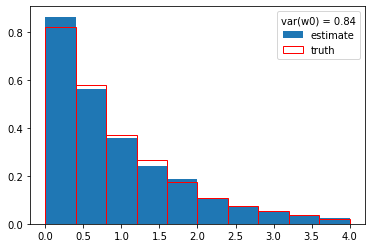

In [281]:
plt.hist(y, weights=w0, density=True, label="estimate")
plt.hist(s_y, density=True, edgecolor="r", facecolor="None", label="truth")
plt.legend(title=f"var(w0) = {np.var(w0):.2f}");